In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import math
from datetime import timezone, datetime
import json

from tqdm import tqdm

import matplotlib.pyplot as plt
import mplfinance as mpf
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

from dtreeviz import trees
from dtreeviz.models.lightgbm_decision_tree import ShadowLightGBMTree

import sys
sys.path.append('..')
from cpcv_util import *
from optuna_util import *

In [2]:
options = {
    'read_timescaledb': False,
    'optimize_atr': False,
    'train_with_optuna': False,
    'svg_output': False
}

In [3]:
from timescaledb_util import *

# TimescaleDB用のユーティリティライブラリの設定
_pg_config = {
        'user': os.environ['POSTGRES_USER'],
        'password': os.environ['POSTGRES_PASSWORD'],
        'host': os.environ['POSTGRES_HOST'],
        'port': os.environ['POSTGRES_PORT'],
        'database': os.environ['POSTGRES_DATABASE']
    }

# TimescaleDBアクセス用のユーティリティオブジェクトを作成
if options['read_timescaledb'] == True:
    print('Read from timescaledb')
    _dbutil = TimeScaleDBUtil(user = _pg_config['user'], password = _pg_config['password'], host = _pg_config['host'], port = _pg_config['port'], database = _pg_config['database'])

    # 全区間のドルバーの読み込みと保存 (mplfinanceでの表示のためにカラム名を変更している)
    df = _dbutil.load_dollarbars('ftx', 'BTC-PERP', 5000000, '2021-01-01 00:00:00.000+00', '2023-01-01 00:00:00.000+00')
    df.columns = ['Datetime', 'Open', 'High', 'Low', 'Close', 'dollar_volume', 'dollar_buy_volume', 'dollar_sell_volume', 'dollar_liquidation_buy_volume', 'dollar_liquidation_sell_volume', 'dollar_cumsum', 'dollar_buy_cumsum', 'dollar_sell_cumsum']
    df['fee'] = 0.02 / 100
    df.to_pickle('df_ohlcv.pkl')
else:
    # 保存しておいたドルバーを読み込み
    print('Read from df_ohlcv.pkl')
    df = pd.read_pickle('df_ohlcv.pkl')

display(df)

Read from df_ohlcv.pkl


,Datetime,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,dollar_cumsum,dollar_buy_cumsum,dollar_sell_cumsum,fee
0,2021-01-01 00:00:36.894000+00:00,29000.0,29029.5,28942.0,28986.5,4.959114e+06,2.564786e+06,2.394328e+06,15531.15400,0.0000,1.923799e+11,9.610236e+10,9.627756e+10,0.0002
1,2021-01-01 00:02:41.379000+00:00,28986.5,29056.0,28979.5,29024.0,5.079592e+06,3.454632e+06,1.624960e+06,206.27575,9175.8848,1.923850e+11,9.610582e+10,9.627918e+10,0.0002
2,2021-01-01 00:08:30.311000+00:00,29024.0,29035.5,28920.0,28942.0,4.998602e+06,8.668237e+05,4.131778e+06,0.00000,0.0000,1.923900e+11,9.610668e+10,9.628331e+10,0.0002
3,2021-01-01 00:10:12.622000+00:00,28942.0,28961.5,28876.0,28907.0,4.991658e+06,2.499264e+06,2.492394e+06,0.00000,0.0000,1.923950e+11,9.610918e+10,9.628581e+10,0.0002
4,2021-01-01 00:13:09.482000+00:00,28907.0,28911.0,28815.5,28850.0,4.896911e+06,1.380208e+06,3.516703e+06,0.00000,6309.5344,1.923999e+11,9.611056e+10,9.628932e+10,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289625,2022-02-10 14:08:30.175000+00:00,43343.0,43382.0,43287.0,43290.0,4.870829e+06,2.014914e+06,2.855915e+06,0.00000,869601.0551,1.641145e+12,8.135513e+11,8.275937e+11,0.0002
289626,2022-02-10 14:09:05.269000+00:00,43282.0,43368.0,43262.0,43328.0,4.995557e+06,3.379773e+06,1.615784e+06,0.00000,0.0000,1.641150e+12,8.135547e+11,8.275953e+11,0.0002
289627,2022-02-10 14:09:32.103000+00:00,43328.0,43400.0,43316.0,43393.0,5.018838e+06,2.991151e+06,2.027687e+06,0.00000,0.0000,1.641155e+12,8.135577e+11,8.275973e+11,0.0002
289628,2022-02-10 14:09:45.133000+00:00,43395.0,43419.0,43372.0,43397.0,4.980746e+06,2.915359e+06,2.065386e+06,0.00000,0.0000,1.641160e+12,8.135606e+11,8.275994e+11,0.0002


In [4]:
# Richmanbtcさんのチュートリアルの関数をカスタムした関数群

def calc_features(df):
    open = df['Open']
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['dollar_buy_volume'] + df['dollar_sell_volume']
    
    df['CLOSE_LOG'] = np.log(df['Close'])
    df['CLOSE_LOGDIFF'] = df['CLOSE_LOG'].diff()
        
    # ドルバー由来の特徴量を追加
    df['TIME'] = df['Datetime']
    df['DELTA_TIME'] = df['TIME'].diff()
    df['DELTA_TIME'] = df['DELTA_TIME'].view(int) / 1_000_000_000 # 単位は秒
    df['DELTA_TIME_T-1'] = df['DELTA_TIME'].shift(1)
    df['DELTA_TIME_T-2'] = df['DELTA_TIME'].shift(2)
    df['DELTA_TIME_T-3'] = df['DELTA_TIME'].shift(3)
    df['DELTA_TIME_T-4'] = df['DELTA_TIME'].shift(4)
    
    df['DELTA_TIME_T-1/T'] = df['DELTA_TIME_T-1'] / df['DELTA_TIME']
    df['DELTA_TIME_T-2/T'] = df['DELTA_TIME_T-2'] / df['DELTA_TIME']
    df['DELTA_TIME_T-3/T'] = df['DELTA_TIME_T-3'] / df['DELTA_TIME']
    df['DELTA_TIME_T-4/T'] = df['DELTA_TIME_T-4'] / df['DELTA_TIME']
    
    df['BUY_RATIO'] = df['dollar_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    
    df['BUY_RATIO_DIFF'] = df['BUY_RATIO'] - df['BUY_RATIO'].shift(1)
    df['BUY_RATIO_DIFF_T-1'] = df['BUY_RATIO_DIFF'].shift(1)
    df['BUY_RATIO_DIFF_T-2'] = df['BUY_RATIO_DIFF'].shift(2)
    df['BUY_RATIO_DIFF_T-3'] = df['BUY_RATIO_DIFF'].shift(3)
    df['BUY_RATIO_DIFF_T-4'] = df['BUY_RATIO_DIFF'].shift(4)

    df['SELL_RATIO'] = df['dollar_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])

    df['SELL_RATIO_DIFF_T-1'] = df['BUY_RATIO'] - df['BUY_RATIO'].shift(1)
    df['SELL_RATIO_DIFF_T-2'] = df['BUY_RATIO'] - df['BUY_RATIO'].shift(2)
    df['SELL_RATIO_DIFF_T-3'] = df['BUY_RATIO'] - df['BUY_RATIO'].shift(3)
    df['SELL_RATIO_DIFF_T-4'] = df['BUY_RATIO'] - df['BUY_RATIO'].shift(4)

    df['LIQUIDATION_BUY_RATIO'] = df['dollar_liquidation_buy_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_BUY_RATIO_DIFF_T-1'] = df['LIQUIDATION_BUY_RATIO'] - df['LIQUIDATION_BUY_RATIO'].shift(1)
    df['LIQUIDATION_BUY_RATIO_DIFF_T-2'] = df['LIQUIDATION_BUY_RATIO'] - df['LIQUIDATION_BUY_RATIO'].shift(2)
    df['LIQUIDATION_BUY_RATIO_DIFF_T-3'] = df['LIQUIDATION_BUY_RATIO'] - df['LIQUIDATION_BUY_RATIO'].shift(3)
    df['LIQUIDATION_BUY_RATIO_DIFF_T-4'] = df['LIQUIDATION_BUY_RATIO'] - df['LIQUIDATION_BUY_RATIO'].shift(4)

    df['LIQUIDATION_SELL_RATIO'] = df['dollar_liquidation_sell_volume'] / (df['dollar_buy_volume'] + df['dollar_sell_volume'])
    df['LIQUIDATION_SELL_RATIO_DIFF_T-1'] = df['LIQUIDATION_SELL_RATIO'] - df['LIQUIDATION_SELL_RATIO'].shift(1)
    df['LIQUIDATION_SELL_RATIO_DIFF_T-2'] = df['LIQUIDATION_SELL_RATIO'] - df['LIQUIDATION_SELL_RATIO'].shift(2)
    df['LIQUIDATION_SELL_RATIO_DIFF_T-3'] = df['LIQUIDATION_SELL_RATIO'] - df['LIQUIDATION_SELL_RATIO'].shift(3)
    df['LIQUIDATION_SELL_RATIO_DIFF_T-4'] = df['LIQUIDATION_SELL_RATIO'] - df['LIQUIDATION_SELL_RATIO'].shift(4)
    
    df.dropna(inplace = True)
    df = df.reset_index(drop = True)
    
    return df

In [5]:
from sklearn.metrics import mean_squared_error

# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] < pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + 0.5 * pred_std * i)
        true_means.append(_df['true'].mean())

    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    #ax[0, 0].scatter(df.loc[df['true'] != 0,'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='post')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

In [6]:
# 学習に利用しない特徴量はコメントアウトすること
features = sorted([
#    'BUY_RATIO',
    'BUY_RATIO_DIFF_T-1', 'BUY_RATIO_DIFF_T-2', 'BUY_RATIO_DIFF_T-3', 'BUY_RATIO_DIFF_T-4',
#    'SELL_RATIO',
    'SELL_RATIO_DIFF_T-1', 'SELL_RATIO_DIFF_T-2', 'SELL_RATIO_DIFF_T-3', 'SELL_RATIO_DIFF_T-4',
#    'LIQUIDATION_BUY_RATIO',
#    'LIQUIDATION_BUY_RATIO_DIFF_T-1', 'LIQUIDATION_BUY_RATIO_DIFF_T-2', 'LIQUIDATION_BUY_RATIO_DIFF_T-3', 'LIQUIDATION_BUY_RATIO_DIFF_T-4',
#    'LIQUIDATION_SELL_RATIO',
#    'LIQUIDATION_SELL_RATIO_DIFF_T-1', 'LIQUIDATION_SELL_RATIO_DIFF_T-2', 'LIQUIDATION_SELL_RATIO_DIFF_T-3', 'LIQUIDATION_SELL_RATIO_DIFF_T-4',
#    'DELTA_TIME',
#    'DELTA_TIME_T-1', 'DELTA_TIME_T-2', 'DELTA_TIME_T-3', 'DELTA_TIME_T-4',
])

In [7]:
# 保存済みのデータフレームを読み込む
df = pd.read_pickle('df_ohlcv.pkl')

# トレーニングデータに売買アクションと特徴量を追加
df_train = df[(df['Datetime'] >= '2021-01-01 00:00:00+00') & (df['Datetime'] < '2022-01-01 00:00:00+00')].copy()
df_train = calc_features(df_train)

pd.set_option('max_columns', None)
display(df_train)

lgb_util = LightGBMRegressionUtil()

# Optunaを使わないシンプルなregression予測を行い、トレーニング区間を予測する
folds = cpcv_split(df_train)

if options['train_with_optuna'] == True:
    use_optuna = True
else:
    use_optuna = False

lgb_util.train_cv(df_train[features], df_train['CLOSE_LOGDIFF'], folds, use_optuna = use_optuna)

,Datetime,Open,High,Low,Close,dollar_volume,dollar_buy_volume,dollar_sell_volume,dollar_liquidation_buy_volume,dollar_liquidation_sell_volume,dollar_cumsum,dollar_buy_cumsum,dollar_sell_cumsum,fee,CLOSE_LOG,CLOSE_LOGDIFF,TIME,DELTA_TIME,DELTA_TIME_T-1,DELTA_TIME_T-2,DELTA_TIME_T-3,DELTA_TIME_T-4,DELTA_TIME_T-1/T,DELTA_TIME_T-2/T,DELTA_TIME_T-3/T,DELTA_TIME_T-4/T,BUY_RATIO,BUY_RATIO_DIFF,BUY_RATIO_DIFF_T-1,BUY_RATIO_DIFF_T-2,BUY_RATIO_DIFF_T-3,BUY_RATIO_DIFF_T-4,SELL_RATIO,SELL_RATIO_DIFF_T-1,SELL_RATIO_DIFF_T-2,SELL_RATIO_DIFF_T-3,SELL_RATIO_DIFF_T-4,LIQUIDATION_BUY_RATIO,LIQUIDATION_BUY_RATIO_DIFF_T-1,LIQUIDATION_BUY_RATIO_DIFF_T-2,LIQUIDATION_BUY_RATIO_DIFF_T-3,LIQUIDATION_BUY_RATIO_DIFF_T-4,LIQUIDATION_SELL_RATIO,LIQUIDATION_SELL_RATIO_DIFF_T-1,LIQUIDATION_SELL_RATIO_DIFF_T-2,LIQUIDATION_SELL_RATIO_DIFF_T-3,LIQUIDATION_SELL_RATIO_DIFF_T-4
0,2021-01-01 00:13:58.357000+00:00,28850.0,28852.0,28767.5,28767.5,4.943562e+06,8.085778e+05,4.134984e+06,0.00000,1055.43420,1.924048e+11,9.611137e+10,9.629346e+10,0.0002,10.267002,-0.002864,2021-01-01 00:13:58.357000+00:00,48.875,176.860,102.311,348.932,124.485,3.618619,2.093320,7.139274,2.547008,0.163562,-0.118291,-0.218835,0.327275,-0.506687,0.162914,0.836438,-0.118291,-0.337126,-0.009851,-0.516539,0.000000,0.000000,0.000000,0.000000,-0.000041,0.000213,-0.001075,0.000213,0.000213,-0.001593
1,2021-01-01 00:14:29.154000+00:00,28767.5,28799.5,28731.5,28754.0,5.163226e+06,2.562076e+06,2.601150e+06,5523.35525,42156.07315,1.924100e+11,9.611393e+10,9.629606e+10,0.0002,10.266532,-0.000469,2021-01-01 00:14:29.154000+00:00,30.797,48.875,176.860,102.311,348.932,1.587005,5.742767,3.322109,11.330065,0.496216,0.332654,-0.118291,-0.218835,0.327275,-0.506687,0.503784,0.332654,0.214363,-0.004472,0.322803,0.001070,0.001070,0.001070,0.001070,0.001070,0.008165,0.007951,0.006876,0.008165,0.008165
2,2021-01-01 00:16:05.137000+00:00,28755.0,28827.5,28732.5,28827.5,5.005350e+06,3.043999e+06,1.961351e+06,0.00000,11530.48320,1.924150e+11,9.611698e+10,9.629802e+10,0.0002,10.269085,0.002553,2021-01-01 00:16:05.137000+00:00,95.983,30.797,48.875,176.860,102.311,0.320859,0.509205,1.842618,1.065928,0.608149,0.111933,0.332654,-0.118291,-0.218835,0.327275,0.391851,0.111933,0.444587,0.326296,0.107461,0.000000,-0.001070,0.000000,0.000000,0.000000,0.002304,-0.005861,0.002090,0.001015,0.002304
3,2021-01-01 00:18:21.340000+00:00,28827.5,28874.5,28826.5,28860.0,4.999873e+06,4.318738e+06,6.811350e+05,0.00000,0.00000,1.924200e+11,9.612130e+10,9.629870e+10,0.0002,10.270212,0.001127,2021-01-01 00:18:21.340000+00:00,136.203,95.983,30.797,48.875,176.860,0.704705,0.226111,0.358839,1.298503,0.863770,0.255621,0.111933,0.332654,-0.118291,-0.218835,0.136230,0.255621,0.367553,0.700208,0.581917,0.000000,0.000000,-0.001070,0.000000,0.000000,0.000000,-0.002304,-0.008165,-0.000213,-0.001288
4,2021-01-01 00:21:49.918000+00:00,28858.0,28907.0,28790.5,28825.0,4.995764e+06,2.783211e+06,2.212553e+06,964.42320,0.00000,1.924250e+11,9.612408e+10,9.630091e+10,0.0002,10.268998,-0.001213,2021-01-01 00:21:49.918000+00:00,208.578,136.203,95.983,30.797,48.875,0.653008,0.460178,0.147652,0.234325,0.557114,-0.306655,0.255621,0.111933,0.332654,-0.118291,0.442886,-0.306655,-0.051035,0.060898,0.393552,0.000193,0.000193,0.000193,-0.000877,0.000193,0.000000,0.000000,-0.002304,-0.008165,-0.000213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257781,2021-12-31 23:51:02.380000+00:00,46402.0,46440.0,46361.0,46362.0,4.888280e+06,2.019341e+06,2.868939e+06,0.00000,0.00000,1.486005e+12,7.364528e+11,7.495521e+11,0.0002,10.744235,-0.000862,2021-12-31 23:51:02.380000+00:00,248.900,174.192,220.574,385.947,189.570,0.699847,0.886195,1.550611,0.761631,0.413099,-0.074917,-0.117154,0.280449,-0.491563,0.397623,0.586901,-0.074917,-0.192071,0.088378,-0.403185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


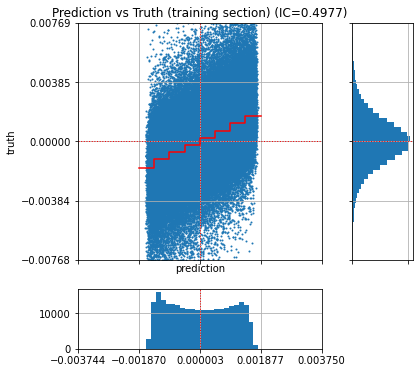

In [8]:
# トレーニング区間のデータに売買アクションと特徴量を追加
df_train = df[(df['Datetime'] >= '2021-01-01 00:00:00+00') & (df['Datetime'] < '2022-01-01 00:00:00+00')].reset_index().copy()
df_train = calc_features(df_train)

# 学習区間について予測を行い、学習したモデルの性能を確認する
df_train['y_pred'] = lgb_util.predict(df_train[features], folds, predict_training = True)

# 真値と予測値の関係を見る
display_true_vs_pred(df_train['CLOSE_LOGDIFF'], df_train['y_pred'], 'Prediction vs Truth (training section)')

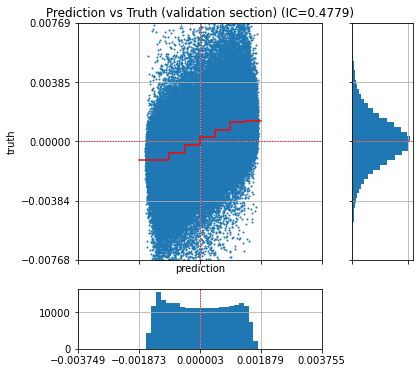

In [9]:
# バリデーション区間について予測を行い、学習したモデルの性能を確認する
df_train['y_pred'] = lgb_util.predict(df_train[features], folds)

# 真値と予測値の関係を見る
display_true_vs_pred(df_train['CLOSE_LOGDIFF'], df_train['y_pred'], 'Prediction vs Truth (validation section)')

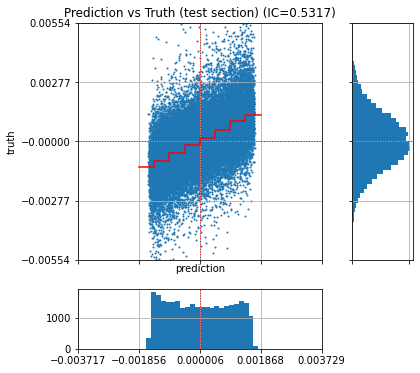

In [10]:
# テスト区間について予測を行い、学習したモデルの性能を確認する
df = pd.read_pickle('df_ohlcv.pkl')
df_test = df[(df['Datetime'] >= '2022-01-01 00:00:00+00') & (df['Datetime'] < '2023-01-01 00:00:00+00')].reset_index().copy()
df_test = calc_features(df_test)

df_test['y_pred'] = lgb_util.predict(df_test[features])

# 真値と予測値の関係を見る
display_true_vs_pred(df_test['CLOSE_LOGDIFF'], df_test['y_pred'], 'Prediction vs Truth (test section)')

<AxesSubplot:title={'center':'Feature importance (delta_t)'}, xlabel='Feature importance', ylabel='Features'>

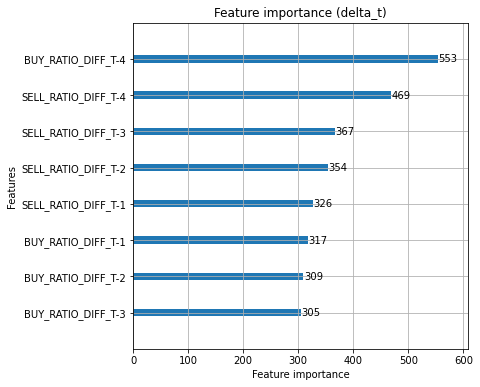

In [11]:
# CPCVによって生成されたboosterのうち一つを選んで特徴量の重要度を表示する
lgb.plot_importance(lgb_util.get_cvbooster().boosters[0], title='Feature importance (delta_t)', figsize=(6, 6))

In [12]:
# dtreevizを利用した決定木の可視化
if options['svg_output'] == True:
    light_dtree_reg = ShadowLightGBMTree(lgb_util.get_cvbooster().boosters[0], tree_index = 1, x_data=df_test[features], y_data=df_test['DELTA_TIME'], feature_names=features, target_name='DELTA_TIME')
    viz = trees.dtreeviz(light_dtree_reg, show_node_labels = True, precision = 6)
    viz.save('./lgb_tree.svg')
    print(f'SVG saved.')